## Importing the required packages

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import vgg19, VGG19_Weights
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math


## Assigning the device as cuda if GPU is available else cpu

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

cuda = torch.device('cuda')

Using cuda device


## Defining the custom dataset and dataloader

In [ ]:
class Div2kDataset(Dataset):
    def __init__(self, rootDir, upscaleFactor=4, transform=None):
        super(Div2kDataset, self).__init__()
        self.rootDir = rootDir
        self.imageFileNames = [f for f in os.listdir(rootDir) if f.endswith('.png')]  # Assumes PNG format
        self.upscaleFactor = upscaleFactor
        self.transform = transform
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


    def __len__(self):
        return len(self.imageFileNames)

    def __getitem__(self, index):
        hrImagePath = os.path.join(self.rootDir, self.imageFileNames[index])
        hrImage = Image.open(hrImagePath).convert("RGB")


        if self.transform:
            hrImage = self.transform(hrImage)

        # Resize HR image to 96x96 (you can change this size if needed)
        resize_transform_hr = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC)
        hrImage = resize_transform_hr(hrImage)

        # Resize HR image to create the corresponding Low-Resolution (LR) image
        width, height = hrImage.size
        resize_transform_lr = transforms.Resize(
            (height // self.upscaleFactor, width // self.upscaleFactor),
            interpolation=transforms.InterpolationMode.BICUBIC
        )
        lrImage = resize_transform_lr(hrImage)


        to_tensor = transforms.ToTensor()
        hrImage = to_tensor(hrImage)
        lrImage = to_tensor(lrImage)


        hrImage = self.normalize(hrImage)
        lrImage = self.normalize(lrImage)

        return hrImage, lrImage

In [ ]:
trainDataset = Div2kDataset("/content/drive/MyDrive/DIV2K_train_HR", 4)
valDataset = Div2kDataset("/content/drive/MyDrive/DIV2K_valid_HR", 4)
trainDataLoader = DataLoader(trainDataset, batch_size = 16, shuffle = True, num_workers = 2)
valDataLoader = DataLoader(valDataset, batch_size = 16, shuffle = True, num_workers = 2)

## Displaying some example of HR and LR images

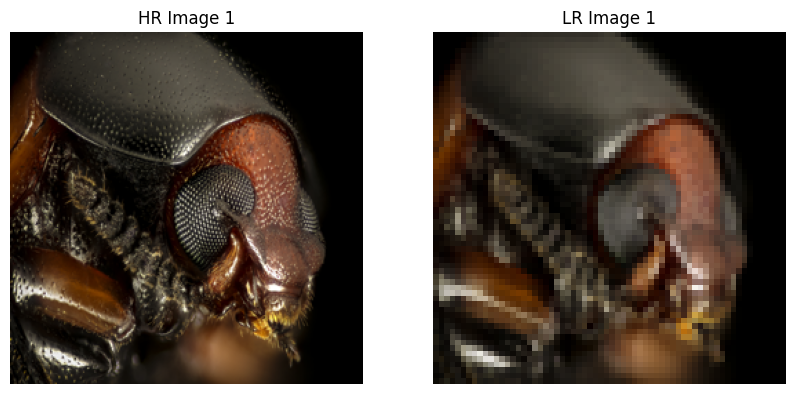

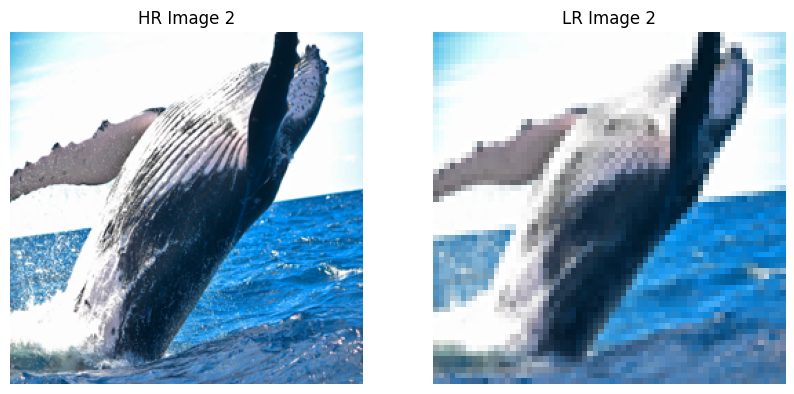

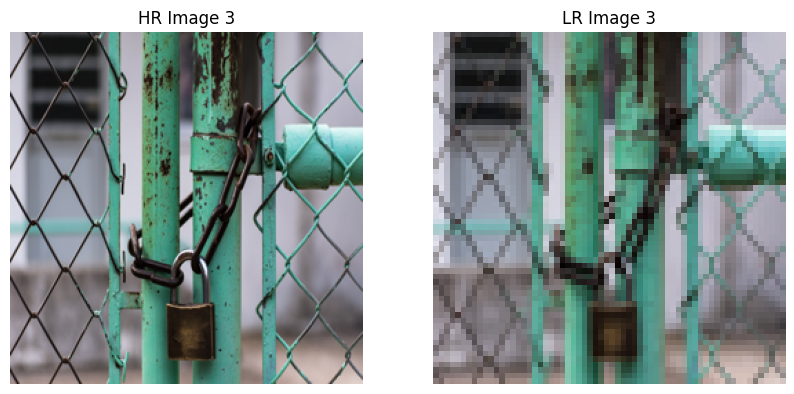

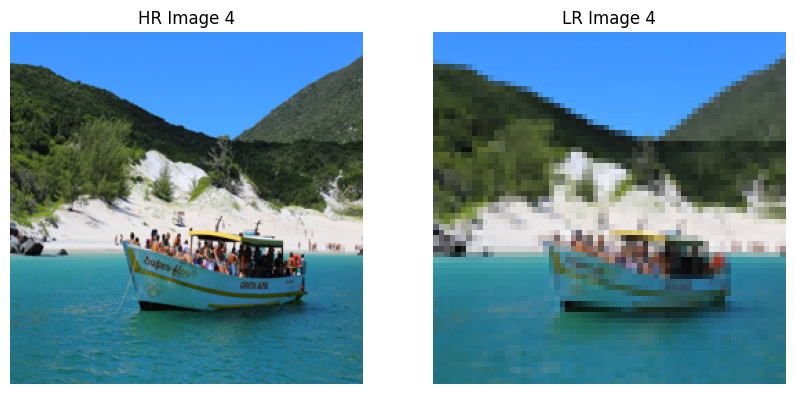

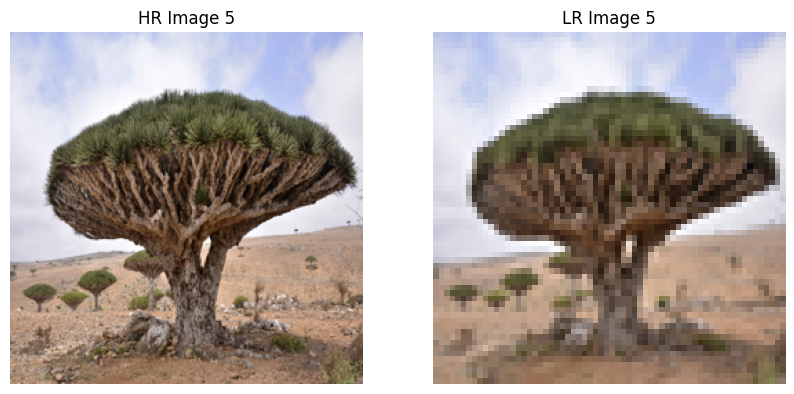

In [ ]:
def unnormalize(image, mean, std):
    img_clone = image.clone().cpu()

    for t, m, s in zip(img_clone, mean, std):
        t.mul_(s).add_(m)

    return img_clone


def display_images(hr_image, lr_image, index, mean, std):

    hr_image = unnormalize(hr_image, mean, std)
    lr_image = unnormalize(lr_image, mean, std)

    hr_image_pil = transforms.ToPILImage()(hr_image)
    lr_image_pil = transforms.ToPILImage()(lr_image)


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))


    axes[0].imshow(hr_image_pil)
    axes[0].set_title(f"HR Image {index}")
    axes[0].axis('off')


    axes[1].imshow(lr_image_pil)
    axes[1].set_title(f"LR Image {index}")
    axes[1].axis('off')

    plt.show()


mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

for i, (hr_image, lr_image) in enumerate(trainDataLoader):
    test_lr_image = lr_image
    if i >= 5:
        break

    display_images(hr_image[0], lr_image[0], i+1, mean, std)


## Defining Residual Blocks and Upsample Blocks for Generator architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channel):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel),
            nn.PReLU(),
            nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channel)
        )

    def forward(self, x):
        return x + self.block(x)


In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

## Defining the Generator architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self, upscaleFactor=4, numOfResidualBlocks=16):
        super(Generator, self).__init__()
        upsample_block_num = int(math.log(upscaleFactor, 2))

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )


        self.residualBlocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(numOfResidualBlocks)]
        )


        self.convBlock = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )


        self.upsample = nn.Sequential(
            *[UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        )


        self.final = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        skip = initial


        residualBlocks = self.residualBlocks(initial)


        convBlock = self.convBlock(residualBlocks) + skip


        upsample = self.upsample(initial)


        final = self.final(upsample)


        return (torch.tanh(final))

## Defining the Discriminator architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__ (self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

#             nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(512, 512, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(1024, 1),
            nn.Sigmoid()

        )

    def forward (self, x):
        x = self.net(x)
        # Flatten the output to (batch_size, 1)
        return x.view(x.size(0), -1)

## example of output shape of Generator and Discriminator

In [ ]:
generator = Generator()
discriminator = Discriminator()

low_res = torch.randn((1, 3, 64, 64))  # Example low-res image batch
generated_hr = generator(low_res)
print("Generated HR Shape:", generated_hr.shape)

real_hr = torch.randn((1, 3, 256, 256))  # Example high-res image batch
disc_out = discriminator(real_hr)
print("Discriminator Output Shape:", disc_out.shape)


Generated HR Shape: torch.Size([1, 3, 256, 256])
Discriminator Output Shape: torch.Size([1, 1])


## Defining the VGGLoss class
The VGGloss class implements a perceptual loss function based on the VGG19 network. Perceptual loss functions are designed to measure the perceptual difference between two images rather than pixel-wise differences.

In [ ]:
class VGGloss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained = True).features[:36].eval()
        self.loss = nn.MSELoss()
    def forward(self, sr_image, target_image):
        vgg_sr_image = self.vgg(sr_image)
        vgg_target_image = self.vgg(target_image)
        return self.loss(vgg_sr_image, vgg_target_image)


## Defining the TVLoss class
The TVLoss class implements Total Variation Loss, a regularization technique commonly used in image restoration and generation tasks to enforce spatial smoothness in generated images. It helps reduce noise or artifacts, ensuring the output image looks more natural and visually appealing.

In [ ]:
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  @staticmethod
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

## Defining the GeneratorLoss class using TVLoss and VGGLoss

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
    def forward(self, out_labels, out_images, target_images):
        adversial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(out_images, target_images)
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

## Denormalize and PSNR claculation functions

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

def denormalize(tensor, mean, std):

    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)

    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)


def calculate_psnr(sr, hr):
    sr_image = denormalize(sr, mean, std)
    hr_image = denormalize(hr, mean, std)
    mse = F.mse_loss(sr_image, hr_image).item()
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0
    psnr = 10 * math.log10((max_pixel_value ** 2) / mse)
    return psnr

## Initializing the Generator and Discriminator and hyperparameters for training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


generator = Generator().to(device)
discriminator = Discriminator().to(device)


generatorLoss = GeneratorLoss().to(device)
adversialLoss = nn.MSELoss()


optimizerG = optim.Adam(generator.parameters(), lr=2e-4)
optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4)

numEpoches = 15
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_g_losses = []
train_d_losses = []
train_psnr_values = []

val_g_losses = []
val_d_losses = []
val_psnr_values = []

for epoch in range(numEpoches):
    generator.train()
    discriminator.train()

    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_psnr = 0
    for hrImage, lrImage in trainDataLoader:
        lrImage = lrImage.to(device)
        hrImage = hrImage.to(device)


        optimizerD.zero_grad()

        srImage = generator(lrImage)



        realLabel = torch.ones(hrImage.size(0), 1).to(device)
        fakeLabel = torch.zeros(hrImage.size(0), 1).to(device)


        realLoss = adversialLoss(discriminator(hrImage), realLabel)
        fakeLoss = adversialLoss(discriminator(srImage.detach()), fakeLabel)

        dLoss = realLoss + fakeLoss
        dLoss.backward()
        optimizerD.step()

        optimizerG.zero_grad()


        gLoss = generatorLoss(discriminator(srImage), srImage, hrImage)

        gLoss.backward()
        optimizerG.step()


        epoch_g_loss += gLoss.item()
        epoch_d_loss += dLoss.item()
        batch_psnr = calculate_psnr(srImage, hrImage)
        epoch_psnr += batch_psnr


    avg_train_g_loss = epoch_g_loss / len(trainDataLoader)
    avg_train_d_loss = epoch_d_loss / len(trainDataLoader)
    avg_train_psnr = epoch_psnr / len(trainDataLoader)

    train_g_losses.append(avg_train_g_loss)
    train_d_losses.append(avg_train_d_loss)
    train_psnr_values.append(avg_train_psnr)

    # Validation
    generator.eval()
    discriminator.eval()


    val_g_loss = 0
    val_d_loss = 0
    val_psnr = 0
    with torch.no_grad():
        val_g_loss = 0
        val_d_loss = 0

        for hrImage, lrImage in valDataLoader:
            lrImage = lrImage.to(device)
            hrImage = hrImage.to(device)

            srImage = generator(lrImage).detach()
            real_labels = torch.ones(hrImage.size(0), 1).to(device)
            fake_labels = torch.zeros(hrImage.size(0), 1).to(device)

            real_loss = adversialLoss(discriminator(hrImage), real_labels)
            fake_loss = adversialLoss(discriminator(srImage), fake_labels)
            val_d_loss += real_loss + fake_loss


            val_g_loss += generatorLoss(discriminator(srImage), srImage, hrImage)


            batch_psnr = calculate_psnr(srImage, hrImage)
            val_psnr += batch_psnr

    avg_val_g_loss = val_g_loss / len(valDataLoader)
    avg_val_d_loss = val_d_loss / len(valDataLoader)
    avg_val_psnr = val_psnr / len(valDataLoader)

    val_g_losses.append(avg_val_g_loss)
    val_d_losses.append(avg_val_d_loss)
    val_psnr_values.append(avg_val_psnr)

    print(f"Epoch [{epoch+1}/{numEpoches}] Loss D: {avg_train_d_loss:.4f}, Loss G: {avg_train_g_loss:.4f}, "
          f"Train PSNR: {avg_train_psnr:.2f} dB, Val PSNR: {avg_val_psnr:.2f} dB, "
          f"Val Loss D: {avg_val_d_loss:.4f}, Val Loss G: {avg_val_g_loss:.4f}")

    # Check for early stopping
    if avg_val_g_loss < best_val_loss:
        best_val_loss = val_g_loss
        early_stop_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'val_g_loss': val_g_loss,
            'val_d_loss': val_d_loss,
        }, '/content/drive/MyDrive/best_model_checkpoint_2.pth')
        print(f"Model saved at epoch {epoch+1}")
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"No improvement in validation loss for {patience} epochs. Stopping training early.")
        break


Epoch [1/15] Loss D: 0.3068, Loss G: 0.1201, Train PSNR: 15.75 dB, Val PSNR: 17.72 dB, Val Loss D: 0.6232, Val Loss G: 0.0688
Model saved at epoch 1
Epoch [2/15] Loss D: 0.3292, Loss G: 0.0585, Train PSNR: 18.50 dB, Val PSNR: 18.67 dB, Val Loss D: 0.5169, Val Loss G: 0.0560
Model saved at epoch 2
Epoch [3/15] Loss D: 0.9299, Loss G: 0.0466, Train PSNR: 19.42 dB, Val PSNR: 19.75 dB, Val Loss D: 1.0804, Val Loss G: 0.0432
Model saved at epoch 3
Epoch [4/15] Loss D: 1.0038, Loss G: 0.0396, Train PSNR: 20.13 dB, Val PSNR: 20.24 dB, Val Loss D: 1.0439, Val Loss G: 0.0387
Model saved at epoch 4
Epoch [5/15] Loss D: 0.9854, Loss G: 0.0363, Train PSNR: 20.54 dB, Val PSNR: 20.76 dB, Val Loss D: 1.0044, Val Loss G: 0.0350
Model saved at epoch 5
Epoch [6/15] Loss D: 0.9932, Loss G: 0.0337, Train PSNR: 20.86 dB, Val PSNR: 20.66 dB, Val Loss D: 1.0714, Val Loss G: 0.0351
Model saved at epoch 6
Epoch [7/15] Loss D: 0.9993, Loss G: 0.0317, Train PSNR: 21.09 dB, Val PSNR: 21.08 dB, Val Loss D: 1.0092,

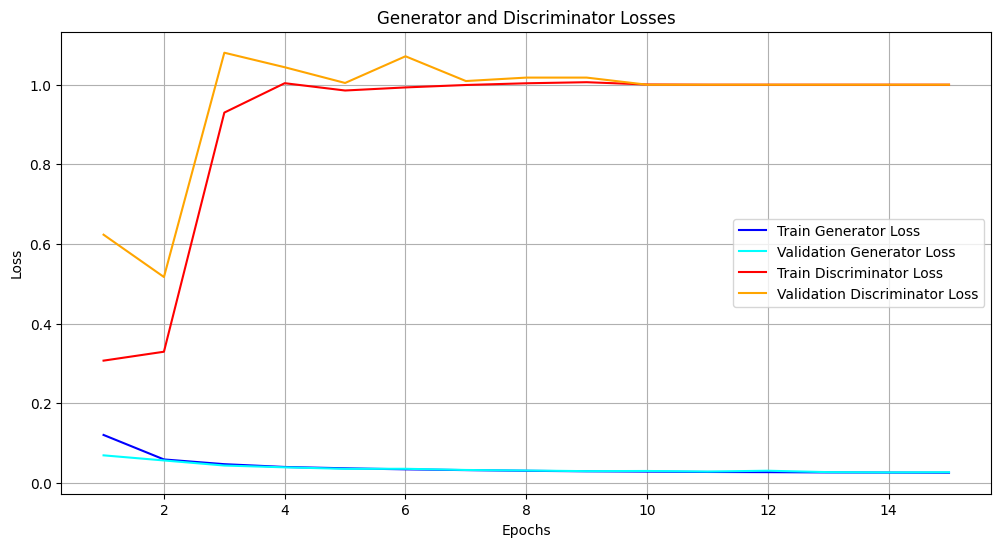

In [ ]:

train_g_losses = [float(loss) for loss in train_g_losses]
train_d_losses = [float(loss) for loss in train_d_losses]
val_g_losses = [float(loss) for loss in val_g_losses]
val_d_losses = [float(loss) for loss in val_d_losses]

epochs = range(1, len(train_g_losses) + 1)

plt.figure(figsize=(12, 6))


plt.plot(epochs, train_g_losses, label='Train Generator Loss', color='blue')
plt.plot(epochs, val_g_losses, label='Validation Generator Loss', color='cyan')


plt.plot(epochs, train_d_losses, label='Train Discriminator Loss', color='red')
plt.plot(epochs, val_d_losses, label='Validation Discriminator Loss', color='orange')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid()

# Show the plot
plt.show()

## Saving the trained version of Generator and Discriminator

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

## Testing the Generator on an image

<ipython-input-11-baa335268f38>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/best_model_checkpoint_2.pth")


Super-Resolved (SR) image shape:  torch.Size([16, 3, 1024, 1024])


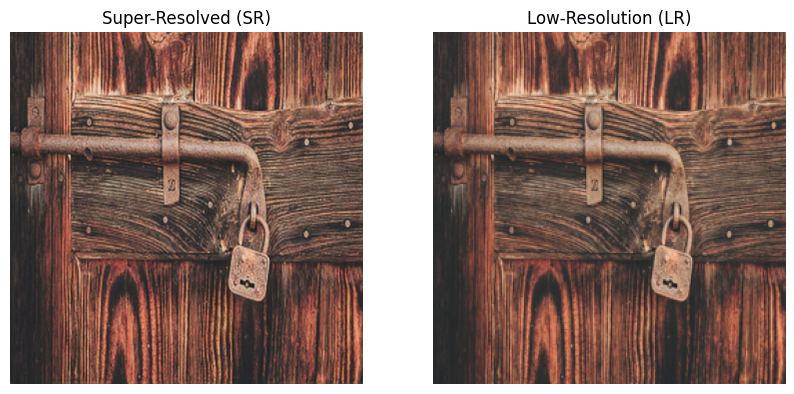

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Load the model (assuming you have a trained model ready)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load("/content/drive/MyDrive/best_model_checkpoint_2.pth")
generator = Generator().to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])

model = generator


for i, (hr_image, lr_image) in enumerate(valDataLoader):
    if i >= 1:
        break
    lr_image = hr_image.to(device)
    model.eval()
    with torch.no_grad():
        sr_image = model(lr_image)


    sr_image = (sr_image.squeeze(0))


    print("Super-Resolved (SR) image shape: ",sr_image.shape)
    hr_image = unnormalize(sr_image[0], mean, std)
    lr_image = unnormalize(lr_image[0], mean, std)

    hr_image_pil = transforms.ToPILImage()(hr_image)
    lr_image_pil = transforms.ToPILImage()(lr_image)


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))


    axes[0].imshow(hr_image_pil)
    axes[0].set_title("Super-Resolved (SR)")
    axes[0].axis('off')


    axes[1].imshow(lr_image_pil)
    axes[1].set_title("Low-Resolution (LR)")
    axes[1].axis('off')

    plt.show()

